# Study of [EPIC210363145](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=210363145)

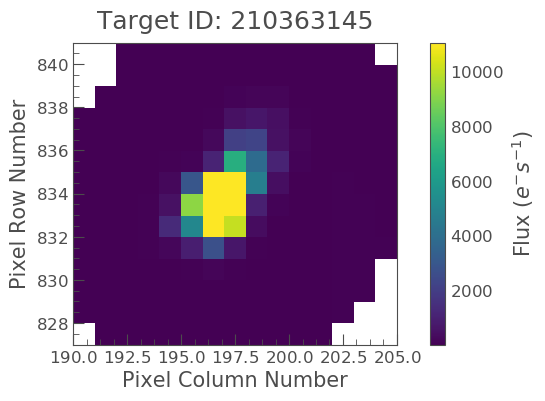

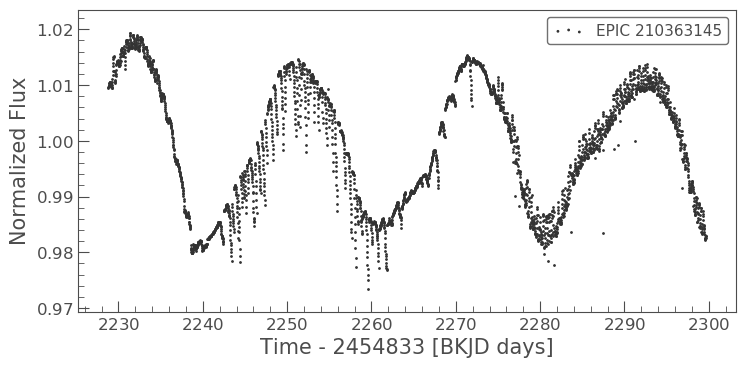

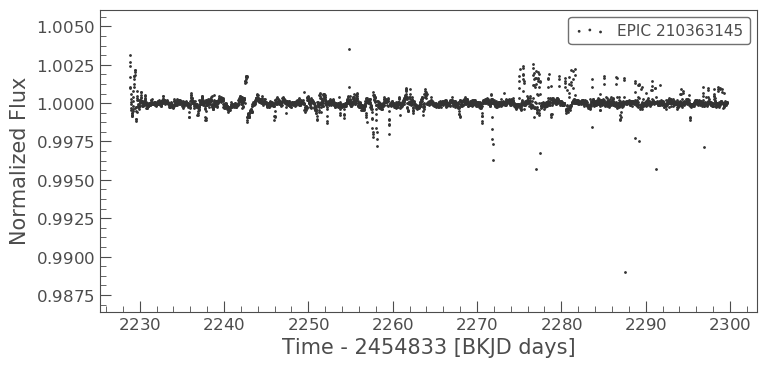

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '210363145'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=10)
corr_lc.scatter()

In [31]:
corr_lc.time_format = 'bjd'

# Creating a file to store the data
f = open("210363145.txt", "w+")

for i in range(len(corr_lc.flux)):
    L = [str(corr_lc.time[i]+2454833), " ", str(corr_lc.flux[i]), " ", str(corr_lc.flux_err[i]), "\n"]
    f.writelines(L)
    
corr_lc.time_format = 'bkjd'

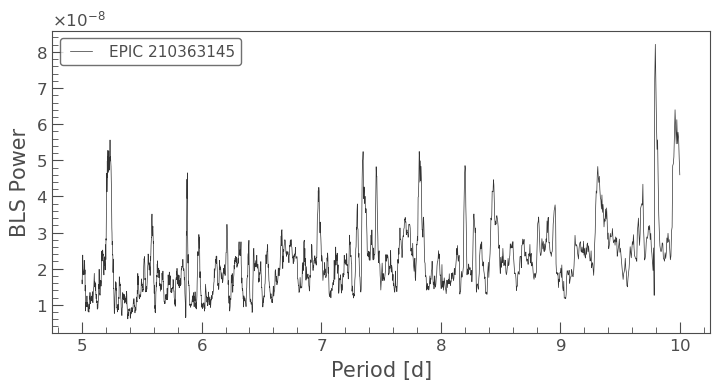

In [15]:
pg = corr_lc.to_periodogram("bls", minimum_period=5, maximum_period=10, frequency_factor=5, duration=0.05)
pg.plot();

(<Time object: scale='tdb' format='jd' value=2457067.5309883635>,
 <Quantity 9.79308727 d>)

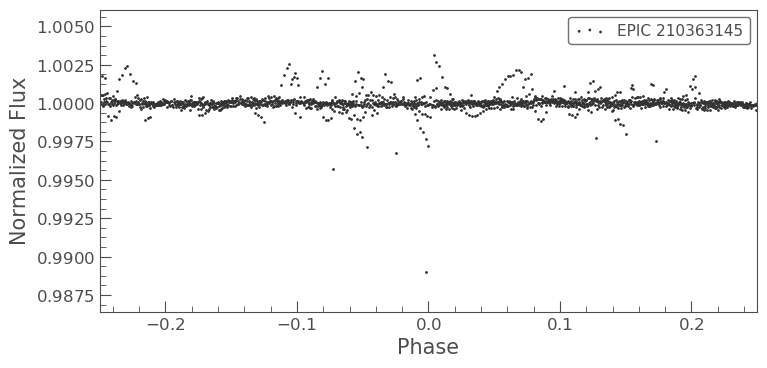

In [16]:
lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(1)
lc_transit.scatter()
plt.xlim([-0.25, 0.25]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

As we cannot see any transit for this period, we are going to try to isolate every peak in the periodogram to find the right one:

(<Time object: scale='tdb' format='jd' value=2457061.857874959>,
 <Quantity 5.23444134 d>)

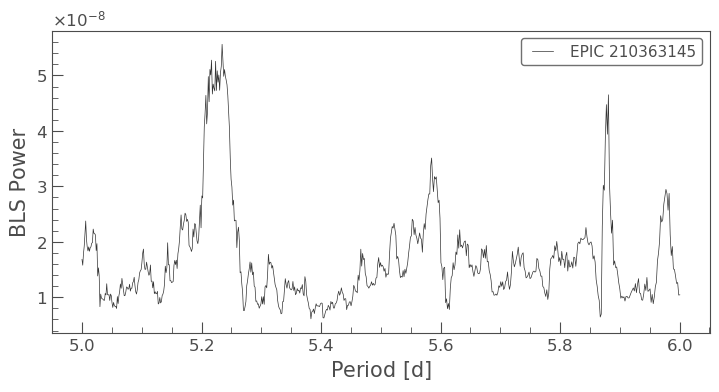

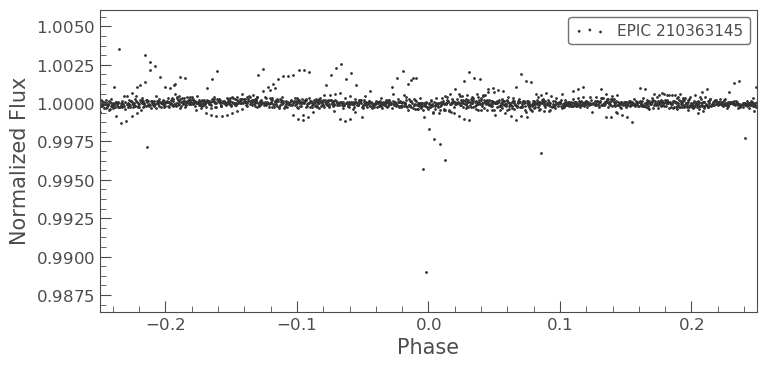

In [20]:
pg = corr_lc.to_periodogram("bls", minimum_period=5, maximum_period=6, frequency_factor=5, duration=0.05)
pg.plot();

lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(1)
lc_transit.scatter()
plt.xlim([-0.25, 0.25]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

(<Time object: scale='tdb' format='jd' value=2457068.5830410984>,
 <Quantity 6.97462961 d>)

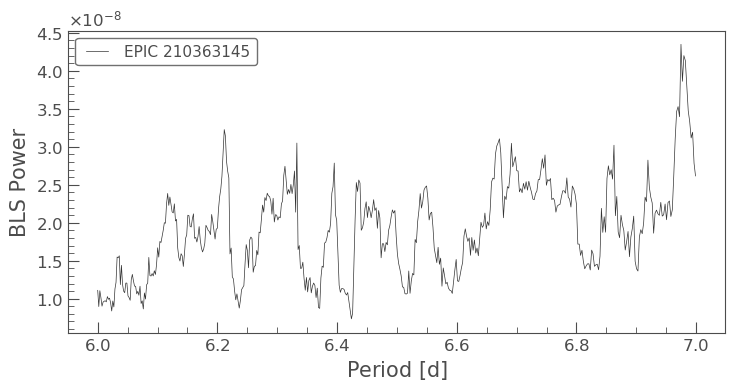

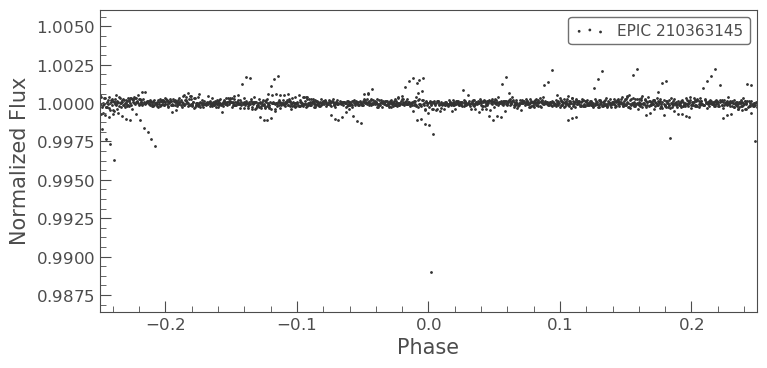

In [21]:
pg = corr_lc.to_periodogram("bls", minimum_period=6, maximum_period=7, frequency_factor=5, duration=0.05)
pg.plot();

lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(1)
lc_transit.scatter()
plt.xlim([-0.25, 0.25]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

(<Time object: scale='tdb' format='jd' value=2457063.2178236325>,
 <Quantity 7.3508127 d>)

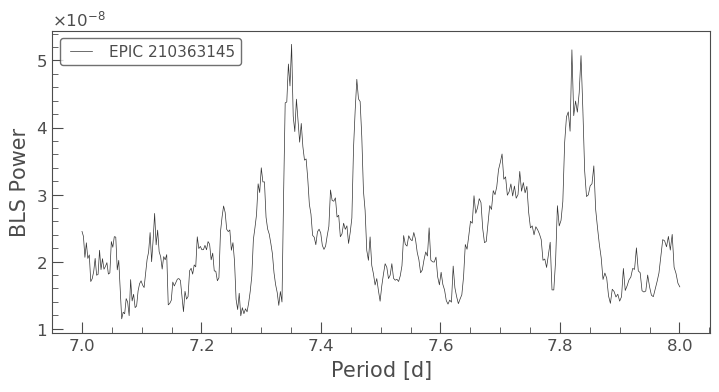

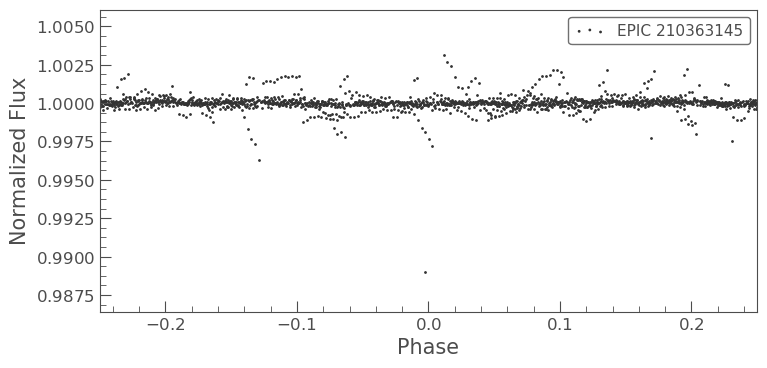

In [22]:
pg = corr_lc.to_periodogram("bls", minimum_period=7, maximum_period=8, frequency_factor=5, duration=0.05)
pg.plot();

lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(1)
lc_transit.scatter()
plt.xlim([-0.25, 0.25]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

(<Time object: scale='tdb' format='jd' value=2457068.527200632>,
 <Quantity 8.20246378 d>)

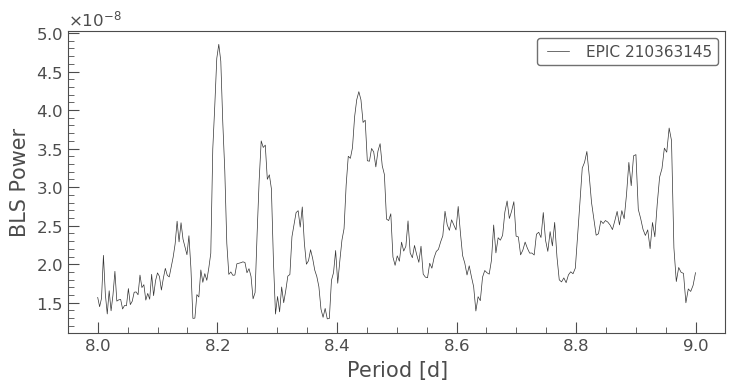

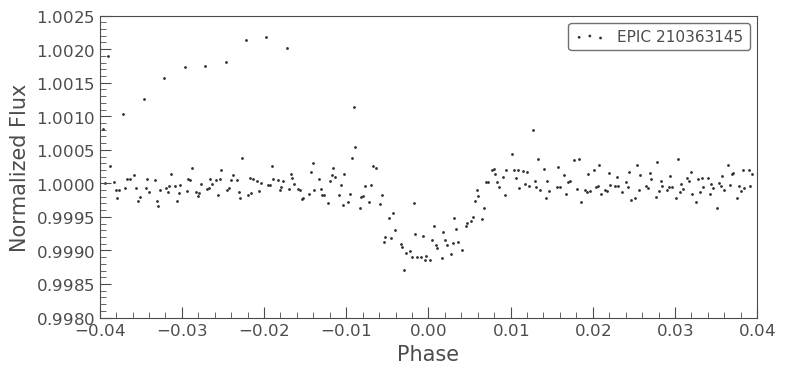

In [26]:
pg = corr_lc.to_periodogram("bls", minimum_period=8, maximum_period=9, frequency_factor=5, duration=0.05)
pg.plot();

lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(1)
lc_transit.scatter()
plt.xlim([-0.04, 0.04]);
plt.ylim([0.998, 1.0025]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

This clearly is the right period!

In [33]:
import math

R_star = 0.83 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.9995]
Td = Td_values[-1] - Td_values[0]

min_tr = lc_transit.flux[lc_transit.flux < 0.9992].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / 695510000 # in jupiter's radius

Td , R_planet

(0.9697096164663321, 0.032106975248422)

In [30]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 0.971*1.98847*10**30
a_m = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a_m)**2 - (Td*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a_au = a_m / (1.496*10**11) #R_star # astronomical unit
a_star = a_m / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a_au, a_star, i, b

(0.07881891107685443,
 20.42586950946358,
 87.1938187446356,
 6.684491952842464e-12)

## Using ExoFAST:

Transit fit:  
Chi^2/dof = 0.00015425627  
Scaling errors by 0.012421320  
RMS of residuals = 0.00049039001  
   
Combined fit:  
Chi^2 of Transit data = 0.023591565 (3131 data points)  
Chi^2 of Priors = 0.29416607 (8 priors)  
Chi^2/dof = 0.00016176704     
      
  
| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 8.232972    |
| a      | Semi-Major Axis                   | AU      | 0.075838    |
| Rp     | Planet Radius                     | Rj      | 0.262348    |
| Teq    | Equilibrium Temperature           | K       | 797.536611  |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.595433    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.135809    |
| i      | Inclination                       | degrees | 87.190027   |
| b      | Impact Parameter                  | none    | 0.951899    |
| delta  | Transit Depth                     | none    | 0.001030    |
| TFWHM  | FWHM Duration                     | days    | 0.001030    |
| tau    | Ingress/Egress Duration           | days    | 0.015111    |
| T14    | Total Duration                    | days    | 0.053906    |